In [1]:
# 引入Python包，在jupyter notebook 运行后可以直接输出多个变量 注意大小写
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
from math import floor
from math import ceil
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

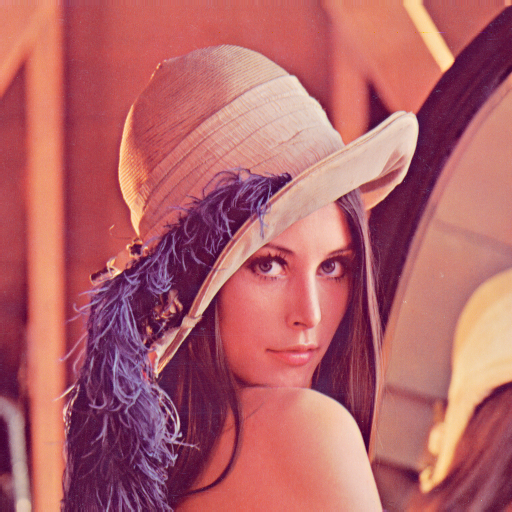

(512, 512)

3

In [3]:
image_path = 'lenna.png'
img = Image.open(image_path).convert('RGB')
img
img.size
num_channel = len(img.split())
num_channel

In [4]:
def Bilinear_interpolation(src_img, target_w, target_h):
    src_w, src_h = src_img.size
    num_channel = len(src_img.split())
    src_img_n = np.array(list(src_img.getdata())).reshape(src_w, src_h, num_channel)
    target_img = np.zeros((target_w, target_h, num_channel), dtype='uint8')
    
    scale_w = src_w / target_w
    scale_h = src_h / target_h
    for tx in range(target_w):
        for ty in range(target_w):
            # 目标位置
            x = (tx - 0.5) * (scale_w) - 0.5
            y = (ty - 0.5) * (scale_h) - 0.5
            
            # 取整得到目标位置周围的4个点
            x0 = int(floor(x)) # 向下取整
            y0 = int(floor(y)) # 向下取整
            
            x1 = int(ceil(x)) # 向上取整
            y1 = int(ceil(y)) # 向上取整
            
            # 做3次双线性插值得到目标点的像素值
            qxy0 = (x1-x)/(x1-x0) * src_img_n[x0, y0] + (x-x0)/(x1-x0) * src_img_n[x0, y1]
            qxy1 = (x1-x)/(x1-x0) * src_img_n[x0, y1] + (x-x0)/(x1-x0) * src_img_n[x1, y1]
            qxy = np.uint8(np.round((y1-y)/(y1-y0) * qxy0 + (y-y0)/(y1-y0) * qxy1))
            
            target_img[tx, ty, :] = qxy
    return target_img

(700, 700, 3)

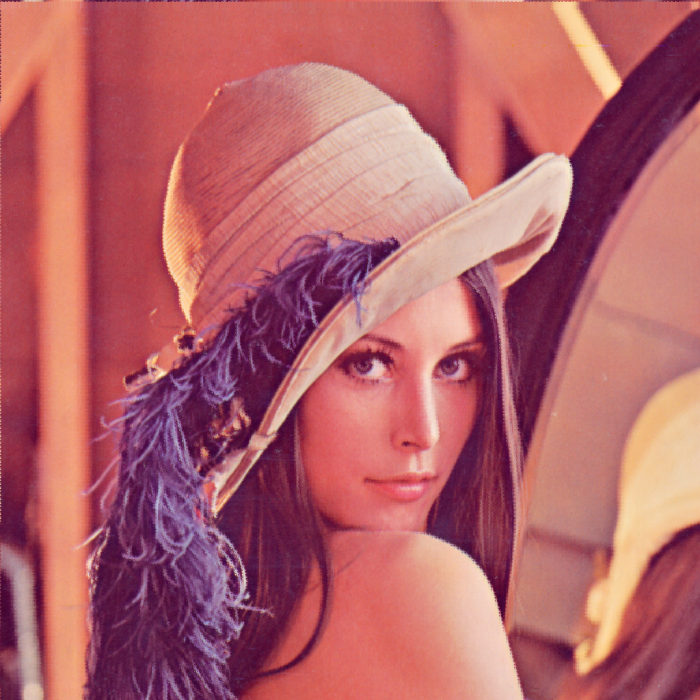

In [5]:
target_iamge = Bilinear_interpolation(img, 700, 700)
target_iamge.shape
# target_iamge
image_show = Image.fromarray(target_iamge)
image_show
image_show.save('lanna_bilinear.png')

In [6]:
# 将for循环改成numpy的矩阵运算，效率提升不是一点两点
# 和 Pllow Image resize的实现一样，差别还是4舍5入的问题

import math

def bilinear_interpolate(src_img, target_w, target_h):
    height_src, width_src = src_img.size
    channel_src = len(src_img.split())
    height_dst, width_dst = target_h, target_w
    src = np.array(list(src_img.getdata())).reshape(width_src, height_src, channel_src)

    """中心对齐，投影目标图的横轴和纵轴到原图上"""
    ws_p = np.array([(i + 0.5) / width_dst * width_src - 0.5 for i in range(width_dst)], dtype=np.float32)
    hs_p = np.array([(i + 0.5) / height_dst * height_src - 0.5 for i in range(height_dst)], dtype=np.float32)
    ws_p = np.clip(ws_p, 0, width_src-1)
    hs_p = np.clip(hs_p, 0, height_src-1)
    ws_p = np.repeat(ws_p.reshape(1, width_dst), height_dst, axis=0)
    hs_p = np.repeat(hs_p.reshape(height_dst, 1), width_dst, axis=1)

    """找出每个投影点在原图的近邻点坐标"""
    ws_0 = np.clip(np.floor(ws_p), 0, width_src - 2).astype(np.int)
    hs_0 = np.clip(np.floor(hs_p), 0, height_src - 2).astype(np.int)
    ws_1 = ws_0 + 1
    hs_1 = hs_0 + 1

    """四个临近点的像素值"""
    f_00 = src[hs_0, ws_0, :].T
    f_01 = src[hs_0, ws_1, :].T
    f_10 = src[hs_1, ws_0, :].T
    f_11 = src[hs_1, ws_1, :].T

    """计算权重"""
    w_00 = ((hs_1 - hs_p) * (ws_1 - ws_p)).T
    w_01 = ((hs_1 - hs_p) * (ws_p - ws_0)).T
    w_10 = ((hs_p - hs_0) * (ws_1 - ws_p)).T
    w_11 = ((hs_p - hs_0) * (ws_p - ws_0)).T

    """计算目标像素值"""
    return np.uint8(np.around((f_00 * w_00).T + (f_01 * w_01).T + (f_10 * w_10).T + (f_11 * w_11).T))

(700, 700, 3)

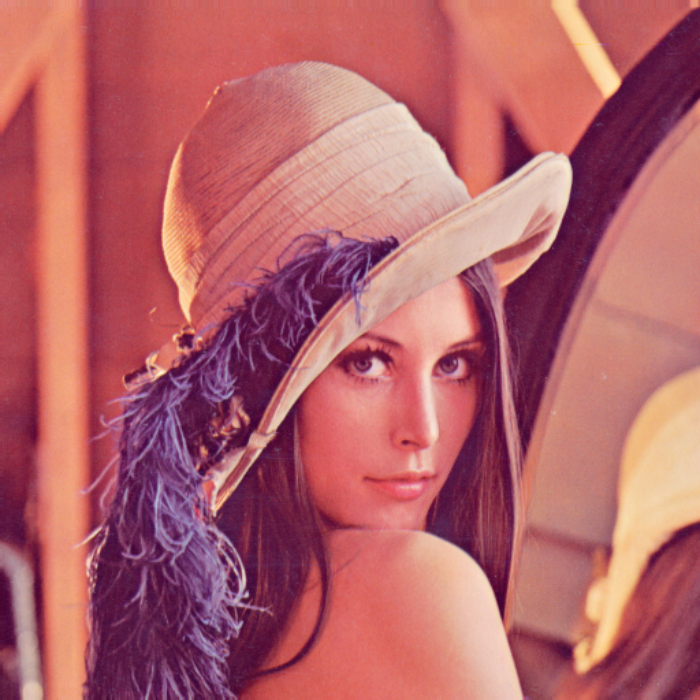

In [7]:
target_iamge = bilinear_interpolate(img, 700, 700)
target_iamge.shape
# target_iamge
image_show = Image.fromarray(target_iamge)
image_show
image_show.save('lanna_bilinear_01.png')

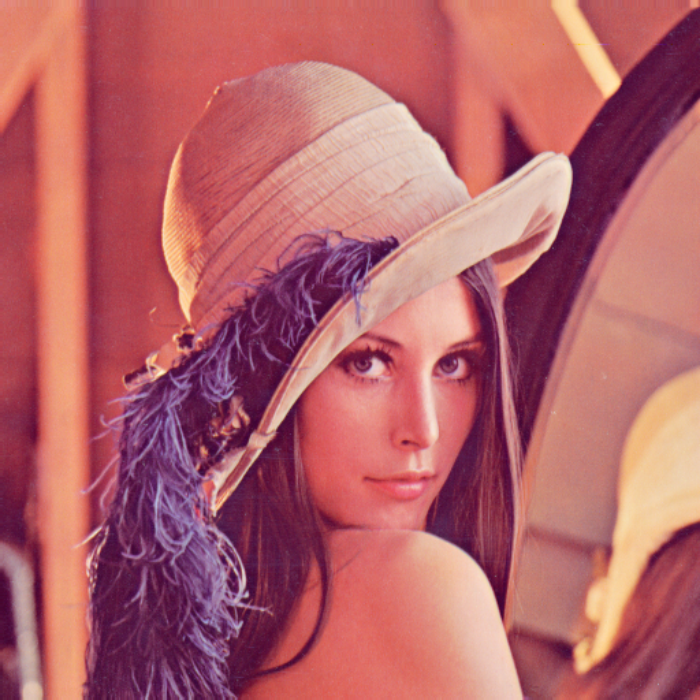

In [8]:
image_resize = img.resize((700, 700), resample=Image.BILINEAR)
image_resize
image_resize.save('lanna_bilinear_pil.png')